# 라이브러리

In [28]:
# 데이터 불러오기
import psycopg2
import json

# 데이터 전처리
import pandas as pd
import numpy as np
import re
import datetime

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

# 기타
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [199]:
#Cluster된 데이터 불러오기
import pickle
clustered = pd.read_pickle("./data/clustered_apartment.pkl")
clustered.head(5)

,apartment_id,cluster
0,1,10
1,3,5
2,4,10
3,5,3
4,6,10


In [200]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [201]:
price = call_df('crawling_db.price_table')
price['area'] = price['area'].apply(lambda x: int(re.split('\D',x)[0]))
apartment = call_df('crawling_db.apartment_table')
apartment = apartment[['apartment_id','apartment_name']]

In [202]:
df = (apartment.
      merge(clustered, how='left', on='apartment_id').
      merge(price, how='left', on='apartment_id'))

In [203]:
df['period'] = pd.to_datetime(df['period'], format='%Y.%m')

In [353]:
df = df[['period','apartment_name','area','amount','cluster']]
df.head(5)

,period,apartment_name,area,amount,cluster
0,2020-03-01,상수두산위브,104.0,1.200000e+09,15
1,2020-02-01,상수두산위브,104.0,1.200000e+09,15
2,2019-12-01,상수두산위브,104.0,1.035000e+09,15
3,2019-11-01,상수두산위브,104.0,1.025000e+09,15
4,2019-10-01,상수두산위브,104.0,9.600000e+08,15


# 데이터 전처리

In [686]:
#사용자 옵션
user_option = {
    'apartment_name':'상수두산위브', # 검색하고 싶은 아파트의 이름
    'apartment_area':104, # 그 아파트의 면적
}

In [687]:
#해당 cluster 찾기
group_name = df.loc[df['apartment_name'] == user_option['apartment_name'],'cluster'].values[0]
print(f"{user_option['apartment_name']} 아파트의 그룹은 {group_name}입니다.")

상수두산위브 아파트의 그룹은 15입니다.


In [688]:
#cluster에 해당 되는 모든 아파트를 담은 dataframe
chosen_cl = df[df['cluster']==group_name]
chosen_cl

,period,apartment_name,area,amount,cluster
0,2020-03-01,상수두산위브,104.0,1.200000e+09,15
1,2020-02-01,상수두산위브,104.0,1.200000e+09,15
2,2019-12-01,상수두산위브,104.0,1.035000e+09,15
3,2019-11-01,상수두산위브,104.0,1.025000e+09,15
4,2019-10-01,상수두산위브,104.0,9.600000e+08,15
...,...,...,...,...,...
458435,2020-01-01,주함해븐,164.0,4.700000e+08,15
458436,2010-01-01,주함해븐,164.0,4.200000e+08,15
458935,NaT,e-푸른,NaN,NaN,15
458997,2020-02-01,센트럴파크55,59.0,4.330000e+08,15


In [689]:
#날짜만 있는 빈 dataframe
empty = df['period'].sort_values().reset_index()
empty = empty.dropna(axis=0).drop_duplicates(['period'])

In [690]:
#사용자 옵션에 해당 하는 아파트와 면적을 지닌 dataframe
chosen = df[(df['apartment_name'] == user_option['apartment_name']) &
            (df['area'] <= user_option['apartment_area']+3) &
            (df['area'] >= user_option['apartment_area']-3)]

In [697]:
#빈 dataframe에 해당 옵션에 해당하는 dataframe을 합치면 값이 없는 곳에 na로 채워지게 된다.
temp = empty.merge(chosen,how='left',on='period')
temp.groupby(temp['period']).mean()
temp = temp.reset_index()
temp = temp[['period','amount']]

In [698]:
#처음 거래된 날짜로 부터 시작을 해본다
starting_point = temp[temp['amount'].notnull()].index[0]
ending_point = temp[temp['amount'].notnull()].index[-1]
temp = temp[starting_point:ending_point+1].reset_index()
temp = temp[['period','amount']]
temp.head(10)

,period,amount
0,2006-01-01,390000000.0
1,2006-02-01,NaN
2,2006-03-01,NaN
3,2006-04-01,550000000.0
4,2006-05-01,NaN
5,2006-06-01,501999999.0
6,2006-07-01,NaN
7,2006-08-01,NaN
8,2006-09-01,NaN
9,2006-10-01,520000000.0


In [708]:
# na 값 채워주기 
stopping = True
for index, row in temp.iterrows():
    if np.isnan(temp['amount'][index]):
        new_index = index
        starts = temp['amount'][index-1]
        
        while stopping:
            if np.isnan(temp['amount'][new_index+1]):
                new_index += 1
            else:
                ends = temp['amount'][new_index+1]
                stopping = False
        
        new = chosen_cl[chosen_cl['period']==temp['period'][index]]
        
        if starts > ends :
            groups = new[(new['amount'] <= starts) & (new['amount'] >= ends)]
        else:
            groups = new[(new['amount'] <= ends) & (new['amount'] >= starts)]
        
        if groups.empty:
            temp['amount'][index] = (starts+ends)/2
        else:
            temp['amount'][index] = groups['amount'].max()   

In [701]:
temp = temp.set_index('period')
temp

,amount
period,
2006-01-01,3.900000e+08
2006-02-01,5.400000e+08
2006-03-01,5.500000e+08
2006-04-01,5.500000e+08
2006-05-01,5.500000e+08
...,...
2019-11-01,1.025000e+09
2019-12-01,1.035000e+09
2020-01-01,1.017000e+09


# 모델링

In [709]:
## 19년 12월까지의 데이터만 train하고, 나머지 20년 1~4월까지는 test하기 위해 쪼갠다
temp_for_train = temp[0:len(temp)-4]
temp_for_test = temp[len(temp)-4:len(temp)]

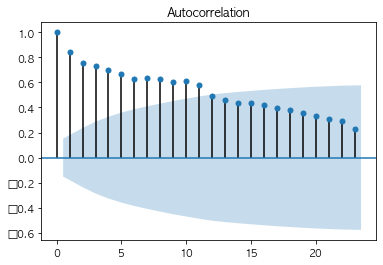

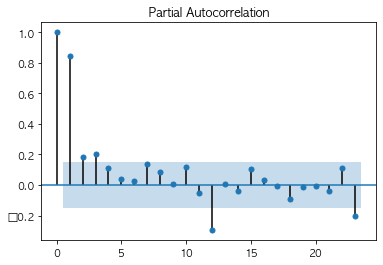

In [710]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(temp_for_train)
plot_pacf(temp_for_train)
plt.show()

In [703]:
#혹시나 하여 돌려보겠습니다
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(temp, order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.amount   No. Observations:                  170
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3235.201
Method:                       css-mle   S.D. of innovations       44505060.965
Date:                Thu, 04 Jun 2020   AIC                           6476.403
Time:                        02:16:04   BIC                           6485.810
Sample:                    02-01-2006   HQIC                          6480.220
                         - 03-01-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.765e+06   2.04e+06      2.333      0.021    7.63e+05    8.77e+06
ma.L1.D.amount    -0.4111      0.088     -4.658      0.000      -0.584      -0.238
                                    

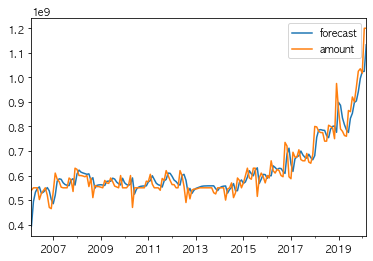

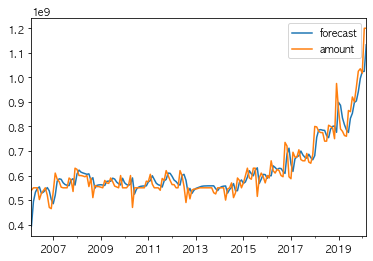

In [711]:
model_fit.plot_predict()

In [714]:
fore = model_fit.forecast(steps=4)
arima = pd.DataFrame(fore[0])
arima.columns = ['arima']
arima.index = temp_for_test.index

In [715]:
result = pd.concat([temp_for_test,arima],axis=1)
result.columns = ['real','model']
result

,real,model
period,,
2019-12-01,1.035000e+09,1.177048e+09
2020-01-01,1.017000e+09,1.181812e+09
2020-02-01,1.200000e+09,1.186577e+09
2020-03-01,1.200000e+09,1.191342e+09


결론: 결과가 좀 괜찮네요. 더 손봐야겠습니다.